<a href="https://colab.research.google.com/github/KhadeejaArshadAli/ClarityX-Ophthalmologist-at-Home-/blob/main/fyp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Disease Categories and Severity Levels**
The dataset includes images from the following four classes, with severity levels defined for three of the diseases:

# **Cataract:**

*   Mild: Early-stage cataract with slight cloudiness in the lens.
*   Moderate: Increased lens opacity causing noticeable visual impairment.
*   Severe: Advanced cataract with significant vision loss and difficulty
    in daily activities.

# **Diabetic Retinopathy:**

*   Mild: Presence of microaneurysms with minimal effect on vision.
*   Moderate: Development of hemorrhages and retinal swelling.
*   Severe: Proliferative stage with abnormal blood vessel growth, posing
    a risk of blindness.

# **Glaucoma:**


*   Early: Slight damage to the optic nerve with no or minor vision loss.
*   Progressed: Significant optic nerve damage leading to peripheral
    vision loss and potential blindness.

# **Normal:**

*   Retinal images from individuals without any signs of the above
    conditions.



# **Data link:**<br>
https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split      # dividing the dataset
from sklearn.preprocessing import LabelEncoder            # for converting str labels to number
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sn
import random


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint ,Callback # type: ignore
from tensorflow.keras import layers, models ,optimizers # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D # type: ignore
from tensorflow.keras.applications import EfficientNetB0 # type: ignore
import pathlib

import warnings
warnings.filterwarnings("ignore")

# Exploratory analysis of image data

In [ ]:
import os
from PIL import Image
from collections import defaultdict

def process_folder(path, normal_folder="normal"):
    # Identify if the current folder is the "normal" folder
    is_normal_folder = os.path.basename(path) == normal_folder
    format_dimensions_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

    if is_normal_folder:
        print(f"Processing '{normal_folder}' folder without diving deeper.")
    else:
        print(f"Processing folder: {path}")

    subfolders_or_files = os.listdir(path)

    for item in subfolders_or_files:
        item_path = os.path.join(path, item)

        # If it's a directory and not the normal folder, process it recursively
        if os.path.isdir(item_path) and not is_normal_folder:
            process_folder(item_path, normal_folder)
        elif os.path.isfile(item_path):  # Process files
            try:
                with Image.open(item_path) as img:
                    image_type = img.format.upper()  # Format (e.g., JPEG, PNG)
                    image_dimensions = img.size  # (width, height)
                    image_mode = img.mode  # Mode (e.g., RGB, L)

                    # Calculate bit depth
                    if image_mode == "1":  # 1-bit pixels, black and white, stored with one pixel per byte
                        bit_depth = 1
                    elif image_mode == "L":  # 8-bit pixels, grayscale
                        bit_depth = 8
                    elif image_mode == "P":  # 8-bit pixels, mapped to any other mode using a color palette
                        bit_depth = 8
                    elif image_mode == "RGB":  # 8-bit pixels, true color
                        bit_depth = 24  # 8 bits per channel
                    elif image_mode == "RGBA":  # 8-bit pixels, true color with transparency mask
                        bit_depth = 32  # 8 bits per channel
                    elif image_mode == "CMYK":  # 8-bit pixels, color separation
                        bit_depth = 32  # 8 bits per channel
                    else:
                        bit_depth = "Unknown"

                    format_dimensions_counts[image_type][(image_dimensions, bit_depth)][image_mode] += 1
            except Exception as e:
                print(f"Exception processing '{item}' in '{path}': {e}")

    # Print results for the current folder
    print('--------' * 10)
    print(f"Folder '{path}' contains:")
    for format, dimensions_counts in format_dimensions_counts.items():
        print(f"- {sum(sum(counts.values()) for counts in dimensions_counts.values())} images of format {format}:")
        for (dimensions, bit_depth), counts in dimensions_counts.items():
            for mode, count in counts.items():
                print(f"  - {count} images with dimensions {dimensions}, bit depth {bit_depth}, mode {mode}")

# Provide the path to your dataset
dataset_path = r'/content/drive/MyDrive/dataset clustered'
process_folder(dataset_path)



Processing folder: /content/drive/MyDrive/dataset clustered
Processing folder: /content/drive/MyDrive/dataset clustered/DiabeticRetinopathy
Processing folder: /content/drive/MyDrive/dataset clustered/DiabeticRetinopathy/ Proliferative
--------------------------------------------------------------------------------
Folder '/content/drive/MyDrive/dataset clustered/DiabeticRetinopathy/ Proliferative' contains:
- 234 images of format PNG:
  - 15 images with dimensions (1504, 1000), bit depth 24, mode RGB
  - 15 images with dimensions (4288, 2848), bit depth 24, mode RGB
  - 45 images with dimensions (3216, 2136), bit depth 24, mode RGB
  - 13 images with dimensions (1844, 1226), bit depth 24, mode RGB
  - 27 images with dimensions (3388, 2588), bit depth 24, mode RGB
  - 62 images with dimensions (2416, 1736), bit depth 24, mode RGB
  - 35 images with dimensions (2588, 1958), bit depth 24, mode RGB
  - 4 images with dimensions (640, 480), bit depth 24, mode RGB
  - 2 images with dimensions

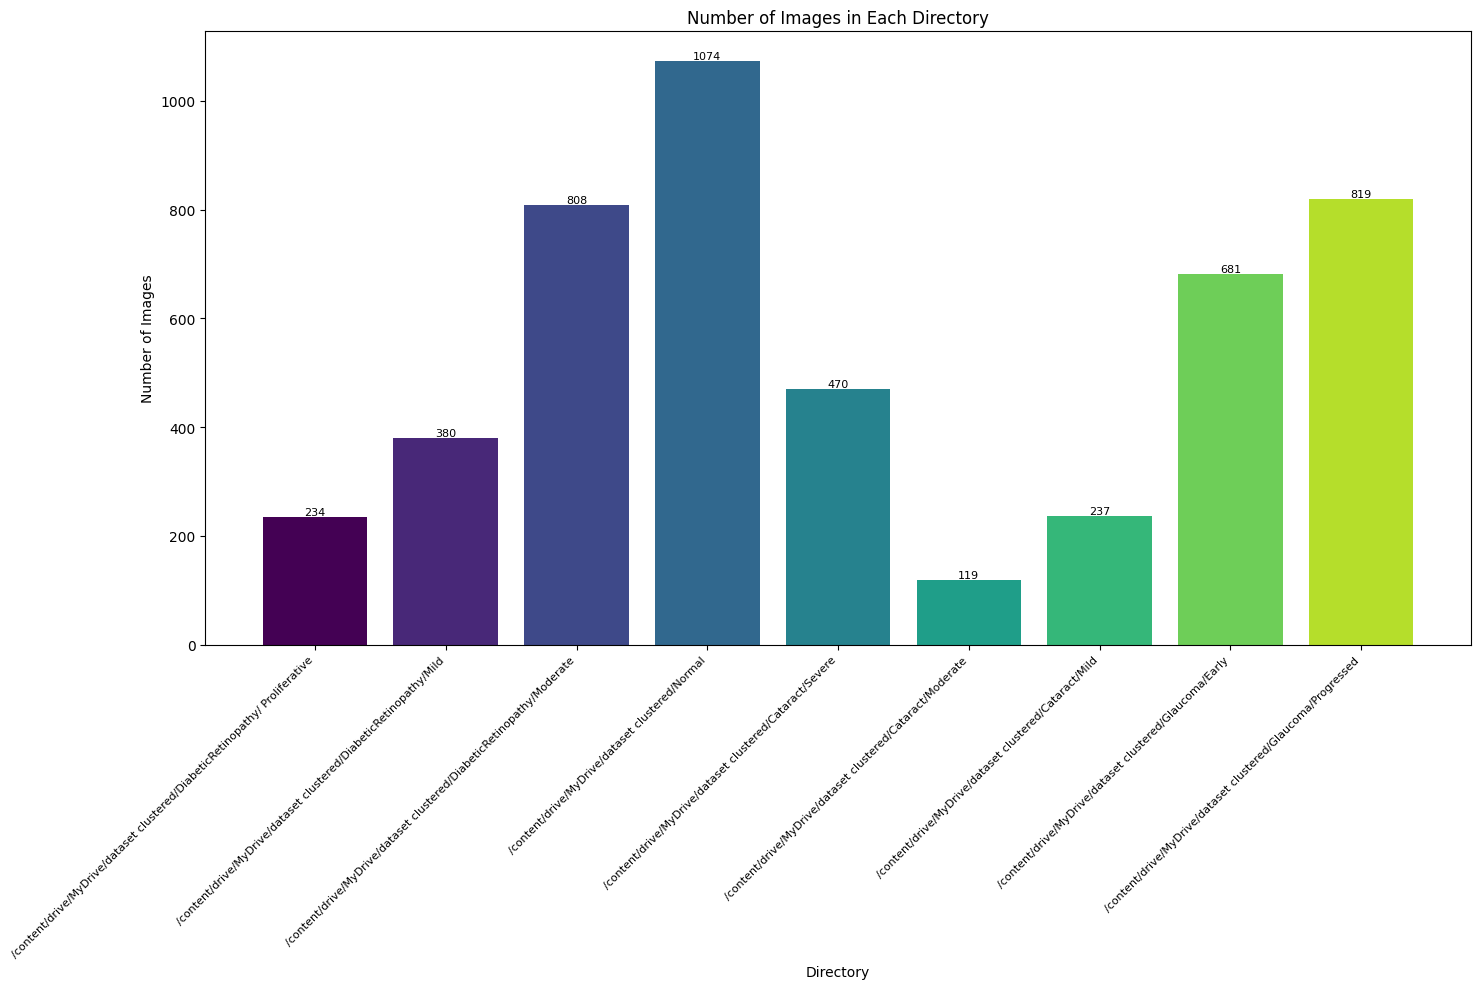

In [ ]:
import os
import matplotlib.pyplot as plt

def count_images_in_directory(path):
    """
    Recursively count the number of images in each subdirectory.
    Returns a dictionary with subdirectory paths as keys and image counts as values.
    """
    image_counts = {}
    for root, dirs, files in os.walk(path):
        # Count only files in the current directory with valid image extensions
        image_count = sum(1 for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')))
        if image_count > 0:  # Include only directories with images
            image_counts[root] = image_count
    return image_counts

# Provide the path to your dataset
dataset_path = r'/content/drive/MyDrive/dataset clustered'

# Count images in all subdirectories
image_counts = count_images_in_directory(dataset_path)

# Prepare data for plotting
subfolders = list(image_counts.keys())
counts = list(image_counts.values())

# Generate a list of colors for each bar
colors = plt.cm.viridis([i / len(subfolders) for i in range(len(subfolders))])

# Plotting the results
plt.figure(figsize=(15, 10))  # Adjust the figure size for better readability
plt.bar(subfolders, counts, color=colors)

# Add value counts on each bar
for i in range(len(subfolders)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom', fontsize=8)

plt.xlabel('Directory')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Directory')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


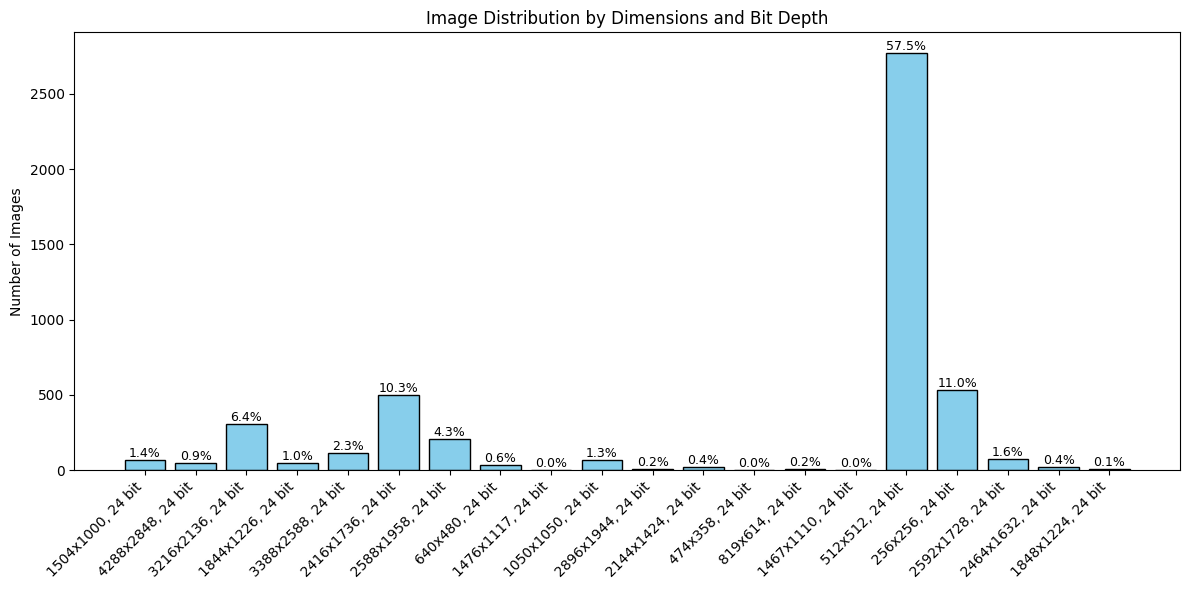

In [ ]:
import os
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt

def dataset_size_analysis(path):
    """
    Analyzes the image dataset by dimensions and bit depth.
    """
    format_dimensions_counts = defaultdict(int)

    # Recursively walk through the dataset
    for root, _, files in os.walk(path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # Open the image and gather properties
                with Image.open(file_path) as img:
                    image_dimensions = img.size
                    image_mode = img.mode

                    # Calculate bit depth based on mode
                    bit_depth = {
                        "1": 1,
                        "L": 8,
                        "P": 8,
                        "RGB": 24,
                        "RGBA": 32,
                        "CMYK": 32
                    }.get(image_mode, "Unknown")

                    # Update counts
                    format_dimensions_counts[(image_dimensions, bit_depth)] += 1

            except Exception as e:
                print(f"Error processing file '{file_path}': {e}")

    # Prepare data for plotting
    labels = [f"{dims[0]}x{dims[1]}, {depth} bit" for dims, depth in format_dimensions_counts.keys()]
    sizes = list(format_dimensions_counts.values())
    total_images = sum(sizes)

    # Plotting the distribution
    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, sizes, color='skyblue', edgecolor='black')
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.ylabel('Number of Images')
    plt.title('Image Distribution by Dimensions and Bit Depth')

    # Adding percentage labels above the bars
    for bar in bars:
        yval = bar.get_height()
        percentage = f'{100 * yval / total_images:.1f}%' if total_images > 0 else '0%'
        plt.text(bar.get_x() + bar.get_width() / 2, yval, percentage, ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_path = r'/content/drive/MyDrive/dataset clustered'
dataset_size_analysis(dataset_path)


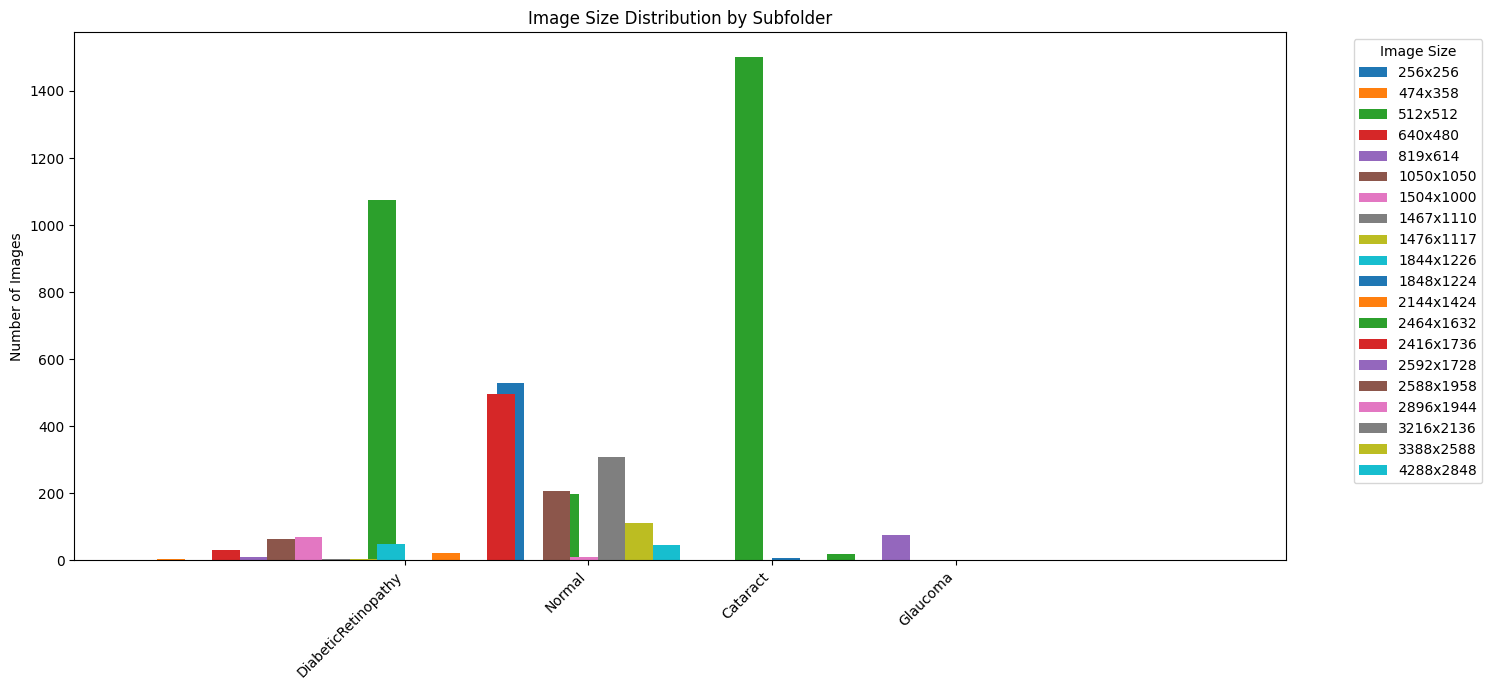

In [ ]:
def dataset_size_analysis(path):
    """
    Analyzes the distribution of image sizes across nested subfolders in the dataset.
    """
    from collections import defaultdict
    from PIL import Image
    import matplotlib.pyplot as plt
    import os

    # Dictionary to store counts: {subfolder: {image_size: count}}
    folder_size_counts = defaultdict(lambda: defaultdict(int))

    # Recursive function to process directories
    def process_directory(directory, parent_folder):
        for item in os.listdir(directory):
            item_path = os.path.join(directory, item)
            if os.path.isdir(item_path):  # If it's a directory, recurse
                process_directory(item_path, parent_folder)
            else:  # If it's a file, process the image
                try:
                    with Image.open(item_path) as img:
                        dims = img.size  # Get image dimensions (width, height)
                        folder_size_counts[parent_folder][dims] += 1
                except Exception as e:
                    print(f"Exception processing '{item}' in '{parent_folder}': {e}")

    # Traverse top-level subfolders
    for subfolder in os.listdir(path):
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            process_directory(subfolder_path, subfolder)

    # Create a single plot
    plt.figure(figsize=(15, 7))

    # Determine unique image sizes across all folders for consistent coloring and grouping
    all_sizes = set(size for sizes in folder_size_counts.values() for size in sizes)
    all_sizes = sorted(all_sizes, key=lambda s: (s[0] * s[1]))  # Sort by area (width x height)

    subfolder_names = list(folder_size_counts.keys())
    bar_width = 0.15  # Width of each bar group
    indices = range(len(subfolder_names))  # X-axis positions for subfolders

    # Plot each image size as a separate bar group
    for i, size in enumerate(all_sizes):
        counts = [folder_size_counts[subfolder].get(size, 0) for subfolder in subfolder_names]
        plt.bar(
            [index + i * bar_width for index in indices],
            counts,
            bar_width,
            label=f'{size[0]}x{size[1]}'
        )

    # Customize the plot
    plt.xticks(
        [index + (len(all_sizes) - 1) * bar_width / 2 for index in indices],
        subfolder_names,
        rotation=45,
        ha="right"
    )
    plt.ylabel('Number of Images')
    plt.title('Image Size Distribution by Subfolder')
    plt.legend(title="Image Size", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_path = r'/content/drive/MyDrive/dataset clustered'
dataset_size_analysis(dataset_path)



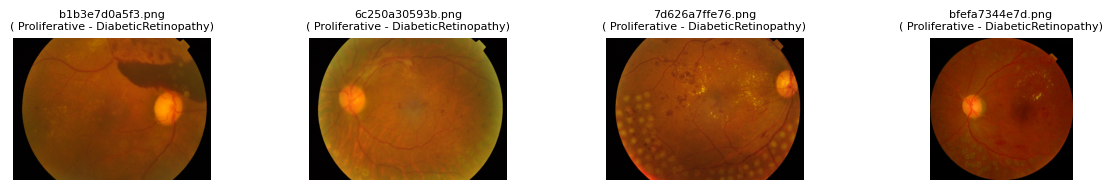

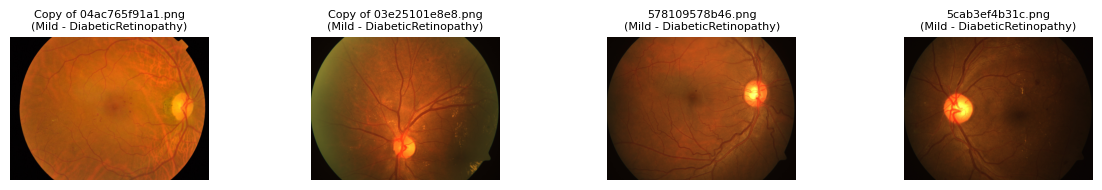

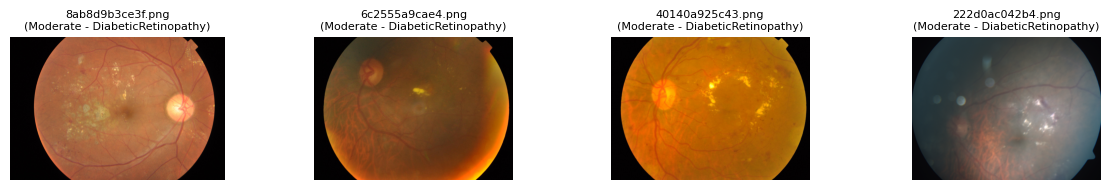

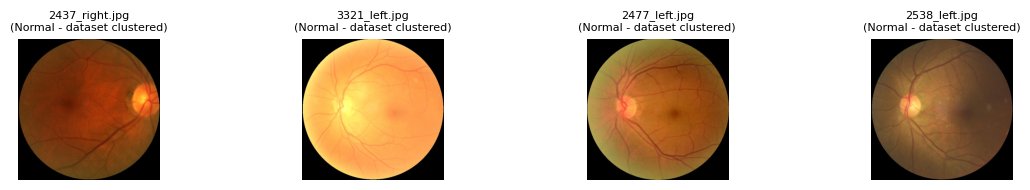

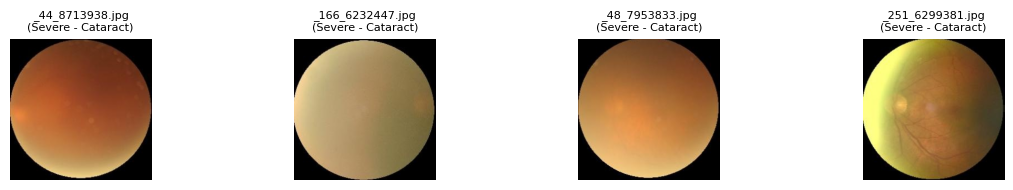

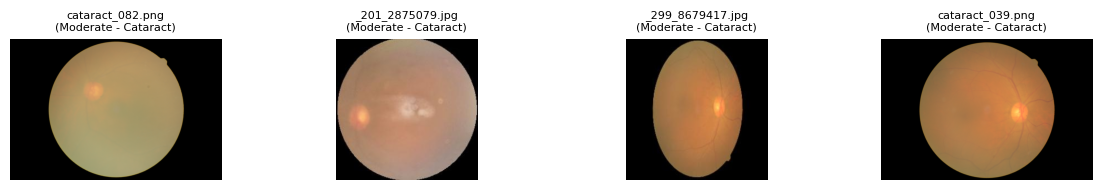

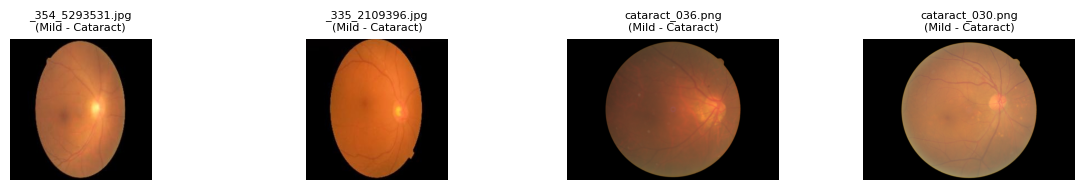

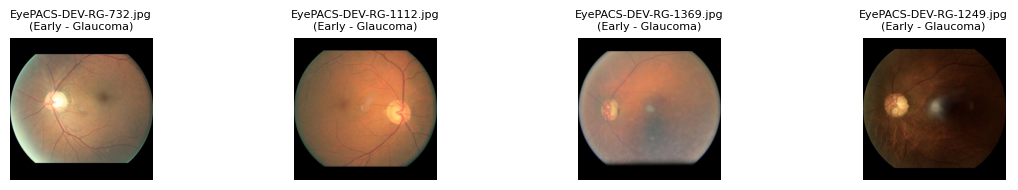

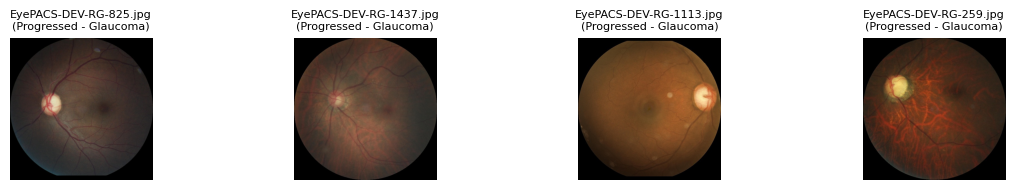

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def random_photos_from_folders(base_folder):
    """
    Randomly selects 4 images from each subfolder and displays them with detailed titles.
    The title includes the image name, the immediate subfolder name, and the parent folder name.
    """
    for root, dirs, files in os.walk(base_folder):
        # Filter to get only files that are images
        images = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if len(images) >= 4:  # Ensure there are at least 4 images
            selected_images = random.sample(images, 4)  # Randomly select 4 images

            # Display selected images
            fig, axs = plt.subplots(1, 4, figsize=(12, 2))  # Create a 1x4 grid of plots
            for idx, img_name in enumerate(selected_images):
                img_path = os.path.join(root, img_name)
                img = Image.open(img_path)

                # Extract subfolder and parent folder names
                subfolder_name = os.path.basename(root)
                parent_folder_name = os.path.basename(os.path.dirname(root))

                # Display the image
                axs[idx].imshow(img)
                axs[idx].axis('off')  # Hide axes

                # Set the title to include image name, subfolder name, and parent folder name
                axs[idx].set_title(f"{img_name}\n({subfolder_name} - {parent_folder_name})", fontsize=8)

            plt.tight_layout()
            plt.show()

# Path to the folder containing subfolders with images
dataset_path = r'/content/drive/MyDrive/dataset clustered'
random_photos_from_folders(dataset_path)


# Data preparation

In [ ]:
import os
import glob
import pandas as pd

def get_image_data_with_nested_classes(base_path):
    """
    Recursively retrieves image file paths and their class labels from nested subfolders.

    Args:
        base_path (str): The root directory containing image subfolders.

    Returns:
        pd.DataFrame: A DataFrame containing image paths and their class labels.
    """
    # List of valid image extensions
    extensions = ["jpg", "JPG", "jpeg", "JPEG", "png", "PNG", "bmp", "BMP", "gif", "GIF"]

    # Data storage
    data = []
    labels = []

    # Walk through the directory tree
    for root, dirs, files in os.walk(base_path):
        for file in files:
            # Check if the file has a valid extension
            if any(file.lower().endswith(ext.lower()) for ext in extensions):
                file_path = os.path.join(root, file)

                # Generate class label based on the folder hierarchy
                relative_path = os.path.relpath(root, base_path)
                class_label = relative_path.replace(os.sep, "_")  # Use "_" to join folder names

                data.append(file_path)
                labels.append(class_label)

    # Check if any data was collected
    if not data:
        print("No image files were found. Check your directory paths and file formats.")
    else:
        print(f"Found {len(data)} image files across {len(set(labels))} classes.")

    # Create a DataFrame with the image paths and labels
    df = pd.DataFrame({
        'filename': data,
        'class': labels
    })

    # Shuffle the dataset
    df = df.sample(frac=1).reset_index(drop=True)
    return df

# Set the path to your dataset
dataset_path = r'/content/drive/MyDrive/dataset clustered'

# Generate the DataFrame
image_data_df = get_image_data_with_nested_classes(dataset_path)

# Display the first few rows
print(image_data_df.head())



Found 4822 image files across 9 classes.
                                            filename  \
0  /content/drive/MyDrive/dataset clustered/Diabe...   
1  /content/drive/MyDrive/dataset clustered/Diabe...   
2  /content/drive/MyDrive/dataset clustered/Catar...   
3  /content/drive/MyDrive/dataset clustered/Glauc...   
4  /content/drive/MyDrive/dataset clustered/Glauc...   

                          class  
0  DiabeticRetinopathy_Moderate  
1  DiabeticRetinopathy_Moderate  
2               Cataract_Severe  
3                Glaucoma_Early  
4           Glaucoma_Progressed  


In [ ]:
display(image_data_df)

filename  \
0     /content/drive/MyDrive/dataset clustered/Diabe...   
1     /content/drive/MyDrive/dataset clustered/Diabe...   
2     /content/drive/MyDrive/dataset clustered/Catar...   
3     /content/drive/MyDrive/dataset clustered/Glauc...   
4     /content/drive/MyDrive/dataset clustered/Glauc...   
...                                                 ...   
4817  /content/drive/MyDrive/dataset clustered/Norma...   
4818  /content/drive/MyDrive/dataset clustered/Catar...   
4819  /content/drive/MyDrive/dataset clustered/Glauc...   
4820  /content/drive/MyDrive/dataset clustered/Diabe...   
4821  /content/drive/MyDrive/dataset clustered/Glauc...   

                                   class  
0           DiabeticRetinopathy_Moderate  
1           DiabeticRetinopathy_Moderate  
2                        Cataract_Severe  
3                         Glaucoma_Early  
4                    Glaucoma_Progressed  
...                                  ...  
4817                              Normal  
4818                       Cataract_Mild  
4819                      Glaucoma_Early  
4820  DiabeticRetinopathy_ Proliferative  
4821                      Glaucoma_Early  

[4822 rows x 2 columns]

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert labels to one-hot encodings
label_encoder = LabelEncoder()
label = label_encoder.fit_transform(image_data_df['class'])
image_data_df['class'] = label

# check number assigned to each class
# Get the class names and corresponding integer encodings
class_names = label_encoder.classes_
class_numbers = label_encoder.transform(label_encoder.classes_)

# Print class names with the assigned numbers
class_dict = dict(zip(class_names, class_numbers))
print(class_dict)

{'Cataract_Mild': 0, 'Cataract_Moderate': 1, 'Cataract_Severe': 2, 'DiabeticRetinopathy_ Proliferative': 3, 'DiabeticRetinopathy_Mild': 4, 'DiabeticRetinopathy_Moderate': 5, 'Glaucoma_Early': 6, 'Glaucoma_Progressed': 7, 'Normal': 8}


In [ ]:
display(image_data_df)

filename  class
0     /content/drive/MyDrive/dataset clustered/Diabe...      5
1     /content/drive/MyDrive/dataset clustered/Diabe...      5
2     /content/drive/MyDrive/dataset clustered/Catar...      2
3     /content/drive/MyDrive/dataset clustered/Glauc...      6
4     /content/drive/MyDrive/dataset clustered/Glauc...      7
...                                                 ...    ...
4817  /content/drive/MyDrive/dataset clustered/Norma...      8
4818  /content/drive/MyDrive/dataset clustered/Catar...      0
4819  /content/drive/MyDrive/dataset clustered/Glauc...      6
4820  /content/drive/MyDrive/dataset clustered/Diabe...      3
4821  /content/drive/MyDrive/dataset clustered/Glauc...      6

[4822 rows x 2 columns]

# Divide data into (train, validation, test)

In dividing the data into three parts, it is important to maintain the distribution ratio of the data in the original dataset. Because I want the three parts of Train + Validation + Test to have the same ratio of data and to have the same amount of data for training for each class.

In [ ]:
from sklearn.model_selection import train_test_split

# Check the balance of the classes
print(image_data_df['class'].value_counts(normalize=True))
print('------'*10)

# Split the data into train+validation and test sets
train_plus_val, test = train_test_split(image_data_df, test_size=0.2, stratify=image_data_df['class'], random_state=42)

# Split the train+validation set into train and validation sets
train, val = train_test_split(train_plus_val, test_size=0.25, stratify=train_plus_val['class'], random_state=42)  # 0.25 x 0.8 = 0.2

# Now you have:
# train: 60% of the data
# val: 20% of the data
# test: 20% of the data

# Confirm the distribution across splits
print("Training set:")
print(train['class'].value_counts(normalize=True))
print('------'*10)


print("Validation set:")
print(val['class'].value_counts(normalize=True))
print('------'*10)


print("Test set:")
print(test['class'].value_counts(normalize=True))

class
8    0.222729
7    0.169847
5    0.167565
6    0.141228
2    0.097470
4    0.078805
0    0.049150
3    0.048528
1    0.024679
Name: proportion, dtype: float64
------------------------------------------------------------
Training set:
class
8    0.222683
7    0.169779
5    0.167358
6    0.141425
2    0.097510
4    0.078838
0    0.049447
3    0.048409
1    0.024550
Name: proportion, dtype: float64
------------------------------------------------------------
Validation set:
class
8    0.222798
7    0.169948
5    0.167876
6    0.140933
2    0.097409
4    0.078756
0    0.048705
3    0.048705
1    0.024870
Name: proportion, dtype: float64
------------------------------------------------------------
Test set:
class
8    0.222798
7    0.169948
5    0.167876
6    0.140933
2    0.097409
4    0.078756
3    0.048705
0    0.048705
1    0.024870
Name: proportion, dtype: float64


In [ ]:
unique, counts = np.unique(train['class'], return_counts=True)
print(dict(zip(unique, counts)))

{0: 143, 1: 71, 2: 282, 3: 140, 4: 228, 5: 484, 6: 409, 7: 491, 8: 644}


# Augmentation




In [ ]:


train['class'] = train['class'].astype(str)


In [ ]:

import os
import shutil

# Define working and augmented directories
working_dir = '/content/drive/MyDrive'
aug_dir = os.path.join(working_dir, 'augmented1000')

# Remove and recreate the augmented directory
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)

# Example: Assuming `train['class']` contains unique class labels
for label in train['class'].unique():
    dir_path = os.path.join(aug_dir, str(label))  # Convert label to string
    os.mkdir(dir_path)

print(os.listdir(aug_dir))


['0', '8', '6', '4', '2', '5', '7', '3', '1']


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

target = 644 # Set the target count for each class in df
gen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
)

groups = train.groupby('class')  # Group by class
for label in train['class'].unique():  # For every class
    group = groups.get_group(label)  # A dataframe holding only rows with the specified label
    sample_count = len(group)  # Determine how many samples there are in this class
    if sample_count < target:  # If the class has less than target number of images
        aug_img_count = 0
        delta = target - sample_count  # Number of augmented images to create
        target_dir = os.path.join(aug_dir, str(label))  # Convert label to string
        os.makedirs(target_dir, exist_ok=True)  # Ensure the directory exists
        aug_gen = gen.flow_from_dataframe(
            group,
            x_col='filename',
            y_col=None,
            target_size=(256, 256),
            class_mode=None,
            batch_size=1,
            shuffle=False,
            save_to_dir=target_dir,
            save_prefix='aug-',
            save_format='jpg',
        )
        while aug_img_count < delta:
            images = next(aug_gen)
            aug_img_count += len(images)


Found 143 validated image filenames.
Found 409 validated image filenames.
Found 228 validated image filenames.
Found 282 validated image filenames.
Found 484 validated image filenames.
Found 491 validated image filenames.
Found 140 validated image filenames.
Found 71 validated image filenames.


In [ ]:

aug_dir='/content/drive/MyDrive/augmented1000'

In [ ]:

aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for klass in classlist:
    classpath=os.path.join(aug_dir, klass)
    flist=os.listdir(classpath)
    for f in flist:
        fpath=os.path.join(classpath,f)
        aug_fpaths.append(fpath)
        aug_labels.append(klass)
Fseries=pd.Series(aug_fpaths, name='filename')
Lseries=pd.Series(aug_labels, name='class')
aug_df=pd.concat([Fseries, Lseries], axis=1)
print ('length of aug_df" ', len(aug_df))
train_df=pd.concat([train,aug_df], axis=0).reset_index(drop=True)
train_df=train_df.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
print ('length of train_df is: ', len(train_df))
print (train_df['class'].value_counts())

length of aug_df"  2904
length of train_df is:  5796
class
3    644
0    644
1    644
2    644
4    644
5    644
7    644
6    644
8    644
Name: count, dtype: int64


AUGMENTATION CELL


In [ ]:

train_df['class'] = train_df['class'].astype(str).str.strip().astype(int)


In [ ]:
train_links, train_labels = train_df['filename'].values , train_df['class'].values
val_links , val_labels = val['filename'].values , val['class'].values
test_links, test_labels = test['filename'].values , test['class'].values
print(train_links , train_labels)


['/content/drive/MyDrive/augmented10001/3/aug-_10_6559909.jpg'
 '/content/drive/MyDrive/augmented10001/0/aug-_9_4094586.jpg'
 '/content/drive/MyDrive/augmented10001/3/aug-_62_4066195.jpg' ...
 '/content/drive/MyDrive/dataset clustered/Normal/2647_left.jpg'
 '/content/drive/MyDrive/augmented10001/6/aug-_61_3052827.jpg'
 '/content/drive/MyDrive/augmented10001/6/aug-_189_7715439.jpg'] [3 0 3 ... 8 6 6]


# Load and Preprocess Images

In [ ]:
# Create a Function to Load and Preprocess Images
# tf.cond is a TensorFlow operation that allows for conditional execution based on the value of a tensor.


def load_and_preprocess_image(path, label, data_augmentation=True):
    # Read the image file
    image = tf.io.read_file(path)

    # Extract file extension
    file_extension = tf.strings.split(path, '.')[-1]

    # Decode based on file extension using tf.cond
    def decode_jpeg():
        return tf.image.decode_jpeg(image, channels=3)

    def decode_png():
        return tf.image.decode_png(image, channels=3)

    def decode_bmp():
        return tf.image.decode_bmp(image, channels=3)

    def decode_gif():
        # Decode GIF and take the first frame
        return tf.squeeze(tf.image.decode_gif(image), axis=0)

    # Handle each format
    image = tf.cond(tf.math.equal(file_extension, 'jpg'), decode_jpeg,
            lambda: tf.cond(tf.math.equal(file_extension, 'jpeg'), decode_jpeg,
            lambda: tf.cond(tf.math.equal(file_extension, 'png'), decode_png,
            lambda: tf.cond(tf.math.equal(file_extension, 'bmp'), decode_bmp,
            lambda: tf.cond(tf.math.equal(file_extension, 'gif'), decode_gif,
            decode_jpeg)))))

    # Resize and normalize
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0  # Normalize to [0, 1] range

    # Apply data augmentation if in training mode
    if data_augmentation == True:
        # Randomly flip the image horizontally
        image = tf.image.random_flip_left_right(image)

        # Randomly flip the image vertically
        image = tf.image.random_flip_up_down(image)

        # Randomly rotate the image
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

        # Randomly adjust brightness
        image = tf.image.random_brightness(image, max_delta=0.1)

        # Randomly zoom in
        image = tf.image.resize_with_crop_or_pad(image, 266, 266)  # Zoom in slightly
        image = tf.image.random_crop(image, size=[256, 256, 3])

        # Randomly adjust contrast
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, label



In [ ]:
import tensorflow as tf

val_dataset = tf.data.Dataset.from_tensor_slices( (val_links , val_labels) )
val_dataset = val_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices( (test_links , test_labels) )
test_dataset = test_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = tf.data.Dataset.from_tensor_slices( (train_links , train_labels) )
train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=True), num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
# Iterate over the dataset and print the first few elements
for data_element, label_element in train_dataset.take(1):  # Adjust the number to print more/less
    print(f"Data: {data_element.numpy()}, Label: {label_element.numpy()}")


Data: [[[0.10169345 0.08491555 0.08319819]
  [0.10169345 0.08491555 0.08319819]
  [0.10169345 0.08491555 0.08319819]
  ...
  [0.10169345 0.08491555 0.08319819]
  [0.10169345 0.08491555 0.08319819]
  [0.10169345 0.08491555 0.08319819]]

 [[0.10169345 0.08491555 0.08319819]
  [0.10169345 0.08491555 0.08319819]
  [0.10169345 0.08491555 0.08319819]
  ...
  [0.10169345 0.08491555 0.08319819]
  [0.10169345 0.08491555 0.08319819]
  [0.10169345 0.08491555 0.08319819]]

 [[0.10169345 0.08491555 0.08319819]
  [0.10169345 0.08491555 0.08319819]
  [0.10169345 0.08491555 0.08319819]
  ...
  [0.10169345 0.08491555 0.08319819]
  [0.10169345 0.08491555 0.08319819]
  [0.10169345 0.08491555 0.08319819]]

 ...

 [[0.02104247 0.01182389 0.00632685]
  [0.02104247 0.01182389 0.00632685]
  [0.02104247 0.01182389 0.00632685]
  ...
  [0.02104247 0.01182389 0.00632685]
  [0.02104247 0.01182389 0.00632685]
  [0.02104247 0.01182389 0.00632685]]

 [[0.02104247 0.01182389 0.00632685]
  [0.02104247 0.01182389 0.0063

In [ ]:
# Iterate over the dataset and print the first few elements
for data_element, label_element in train_dataset.take(1):  # Adjust the number to print more/less
    print(f"Data: {data_element.numpy().shape}, Label: {label_element.numpy()}")



Data: (256, 256, 3), Label: 3


In [ ]:
#prepare your datasets for model training and evaluation

batch_size = 32

train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size= tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
print (len(train_dataset))
print (len(val_dataset))
print (len(test_dataset))

182
31
31


# Image Classification

# Transfer Learning

By setting `include_top=False`, the last fully connected layers are removed and only the base convolutional network is left, which is used when a pre-trained network is required to serve as a feature extractor in transfer learning setup followed by subsequent training of new top layer specific to your dataset.

When you set `base_model.trainable = True`, all the layers in the base model become trainable. In this case, these layers will have their weights updated during training. This method is often used in situations where you have a lot of training data and wish to fine-tune the entire model on your new data for perhaps better performance.

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0

# Define the input shape explicitly
input_shape = (256, 256, 3)

# Define the input layer
inputs = layers.Input(shape=input_shape)

# Load EfficientNetB0 with pre-trained ImageNet weights, excluding the top layers
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)

# Make the base model trainable
base_model.trainable = True

# Add additional layers on top of the base model
x = base_model.output
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)

# Output layer with the number of classes
outputs = layers.Dense(len(class_names), activation='softmax')(x)

# Define the model
model = models.Model(inputs=inputs, outputs=outputs)

# Print the model summary
model.summary()



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,715,180 (17.99 MB)

 Trainable params: 4,670,597 (17.82 MB)

 Non-trainable params: 44,583 (174.16 KB)

Here I tried to use the .keras extension to save the model, but after saving and reloading in transfer learning mode, the weights were not saved correctly, while it worked fine in non-transfer mode. I didn't understand the reason, so I made a custom function to use the .h5 format.

In [ ]:


from tensorflow.keras.callbacks import Callback
#------------------------------------------------------------------------------------------------------#

class CustomEarlyStoppingAndCheckpoint(Callback):
    def __init__(self, save_path, patience=12, verbose=1, save_best_only=True):
        super(CustomEarlyStoppingAndCheckpoint, self).__init__()
        self.save_path = save_path
        self.patience = patience
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best_weights = None
        self.best_acc = -np.Inf
        self.best_loss = np.Inf
        self.wait = 0
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')
        if val_acc is None or val_loss is None:
            return

        # Checkpoint for best loss
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            if self.save_best_only:
                self.model.save(self.save_path, include_optimizer=True)
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: val_loss improved to {val_loss:.4f}, saving model to {self.save_path}")

        # Early stopping for best accuracy
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: early stopping")
                if self.best_weights is not None:
                    self.model.set_weights(self.best_weights)
                    if self.verbose > 0:
                        print("Restoring model weights from the end of the best epoch based on accuracy.")

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print(f"Epoch {self.stopped_epoch + 1}: early stopping triggered")


#----------------------------------------------------------------------------------------------------------#

# Usage of the custom callback
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    CustomEarlyStoppingAndCheckpoint(
        save_path=r'/content/drive/MyDrive/savemodal/bestmodalfinal1000.h5',
        patience=12,
        verbose=1,
        save_best_only=True
    )
]



# Fit the model
history = model.fit(
    x = train_dataset,
    validation_data = val_dataset,
    epochs = 150,
    callbacks= callbacks # Add the EarlyStopping callback
)


Epoch 1/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.5903 - loss: 1.2481


Epoch 1: val_loss improved to 15.4801, saving model to /content/drive/MyDrive/savemodal/bestmodalfinal1000.h5
182/182 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - accuracy: 0.5907 - loss: 1.2463 - val_accuracy: 0.0974 - val_loss: 15.4801
Epoch 2/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.7580 - loss: 0.6173


Epoch 2: val_loss improved to 3.6648, saving model to /content/drive/MyDrive/savemodal/bestmodalfinal1000.h5
182/182 ━━━━━━━━━━━━━━━━━━━━ 171s 941ms/step - accuracy: 0.7581 - loss: 0.6171 - val_accuracy: 0.2197 - val_loss: 3.6648
Epoch 3/150
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.8092 - loss: 0.5116


Epoch 3: val_loss improved to 2.4081, saving model to /content/drive/MyDrive/savemodal/bestmodalfinal1000.h5
182/182 ━━━━━━━━━━━━━━━━━━━━ 170s 936ms/step - accuracy: 0.8092 - loss: 0.5115 - val_accuracy: 0.3492 - val_loss: 2.4081
Epoch 4/150
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.8223 - loss: 0.4542


Epoch 4: val_loss improved to 0.9487, saving model to /content/drive/MyDrive/savemodal/bestmodalfinal1000.h5
182/182 ━━━━━━━━━━━━━━━━━━━━ 200s 928ms/step - accuracy: 0.8224 - loss: 0.4542 - val_accuracy: 0.6974 - val_loss: 0.9487
Epoch 5/150
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.8424 - loss: 0.4280


Epoch 5: val_loss improved to 0.6757, saving model to /content/drive/MyDrive/savemodal/bestmodalfinal1000.h5
182/182 ━━━━━━━━━━━━━━━━━━━━ 202s 929ms/step - accuracy: 0.8425 - loss: 0.4277 - val_accuracy: 0.7585 - val_loss: 0.6757
Epoch 6/150
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.8662 - loss: 0.3380


Epoch 6: val_loss improved to 0.6664, saving model to /content/drive/MyDrive/savemodal/bestmodalfinal1000.h5
182/182 ━━━━━━━━━━━━━━━━━━━━ 167s 917ms/step - accuracy: 0.8663 - loss: 0.3379 - val_accuracy: 0.8021 - val_loss: 0.6664
Epoch 7/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 167s 919ms/step - accuracy: 0.8773 - loss: 0.3307 - val_accuracy: 0.8197 - val_loss: 0.6749
Epoch 8/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 165s 909ms/step - accuracy: 0.8901 - loss: 0.3028 - val_accuracy: 0.7534 - val_loss: 0.9522
Epoch 9/150
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.8907 - loss: 0.3033


Epoch 9: val_loss improved to 0.5536, saving model to /content/drive/MyDrive/savemodal/bestmodalfinal1000.h5
182/182 ━━━━━━━━━━━━━━━━━━━━ 169s 929ms/step - accuracy: 0.8907 - loss: 0.3030 - val_accuracy: 0.8456 - val_loss: 0.5536
Epoch 10/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 200s 918ms/step - accuracy: 0.9065 - loss: 0.2510 - val_accuracy: 0.7378 - val_loss: 0.8619
Epoch 11/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 165s 909ms/step - accuracy: 0.9062 - loss: 0.2552 - val_accuracy: 0.7420 - val_loss: 1.0422
Epoch 12/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 166s 912ms/step - accuracy: 0.9113 - loss: 0.2387 - val_accuracy: 0.8290 - val_loss: 0.5645
Epoch 13/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 168s 921ms/step - accuracy: 0.9113 - loss: 0.2436 - val_accuracy: 0.8010 - val_loss: 0.6988
Epoch 14/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 201s 918ms/step - accuracy: 0.9197 - loss: 0.2209 - val_accuracy: 0.6197 - val_loss: 1.8738
Epoch 15/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 201s 911ms/step - accuracy: 0.9250 - loss: 0.2161 - val_a


Epoch 18: val_loss improved to 0.5433, saving model to /content/drive/MyDrive/savemodal/bestmodalfinal1000.h5
182/182 ━━━━━━━━━━━━━━━━━━━━ 168s 926ms/step - accuracy: 0.9406 - loss: 0.1664 - val_accuracy: 0.8342 - val_loss: 0.5433
Epoch 19/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 200s 917ms/step - accuracy: 0.9325 - loss: 0.1886 - val_accuracy: 0.8415 - val_loss: 0.6790
Epoch 20/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 203s 921ms/step - accuracy: 0.9363 - loss: 0.1697 - val_accuracy: 0.8342 - val_loss: 0.6454
Epoch 21/150
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9430 - loss: 0.1493
Epoch 21: early stopping
Restoring model weights from the end of the best epoch based on accuracy.
182/182 ━━━━━━━━━━━━━━━━━━━━ 165s 906ms/step - accuracy: 0.9430 - loss: 0.1494 - val_accuracy: 0.7824 - val_loss: 0.8813
Epoch 21: early stopping triggered


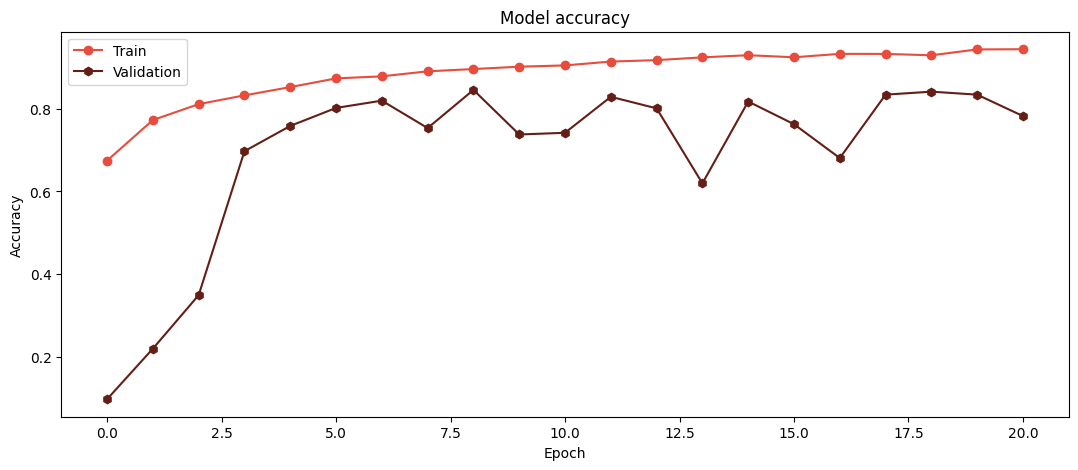

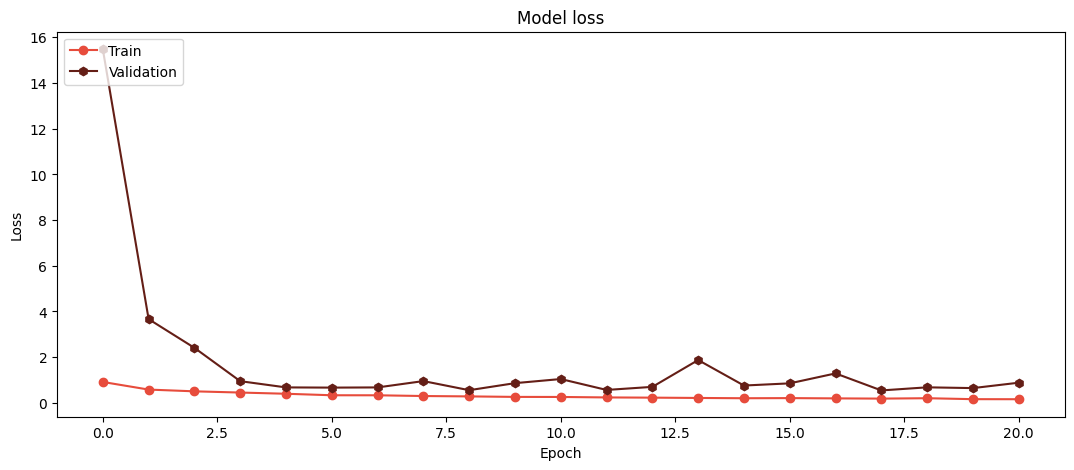

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(13,5))
plt.plot(history.history['accuracy'],color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(13,5))
plt.plot(history.history['loss'],color="#E74C3C", marker='o')
plt.plot(history.history['val_loss'], color='#641E16', marker='h')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( ['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Load the saved model
# If the best model is captured by the early stopping mechanism then best_model = model
# best_model = model
from tensorflow.keras.models import load_model


# Assuming you have a custom layer or object
best_model = load_model(r'/content/drive/MyDrive/savemodal/bestmodalfinal1000.h5', compile=False)
model.summary()
best_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Evaluate the model
train_loss, train_accuracy = best_model.evaluate(train_dataset)
val_loss, val_accuracy = best_model.evaluate(val_dataset)
test_loss, test_accuracy = best_model.evaluate(test_dataset)

print(f"train loss: {train_loss}")
print(f"train accuracy: {train_accuracy}")
print('----'*6)
print(f"val loss: {val_loss}")
print(f"val accuracy: {val_accuracy}")
print('----'*6)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,715,180 (17.99 MB)

 Trainable params: 4,670,597 (17.82 MB)

 Non-trainable params: 44,583 (174.16 KB)

182/182 ━━━━━━━━━━━━━━━━━━━━ 746s 4s/step - accuracy: 0.8890 - loss: 0.3428
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8907 - loss: 0.3818
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9108 - loss: 0.2925
train loss: 0.3263827860355377
train accuracy: 0.8945824503898621
------------------------
val loss: 0.42147260904312134
val accuracy: 0.8829015493392944
------------------------
Test loss: 0.3020854592323303
Test accuracy: 0.8974093198776245


In [ ]:
# Assuming best_model is your trained Keras model

# Get the predicted labels from the model
y_pred = np.argmax( best_model.predict(test_dataset) , axis=1 ) # Convert probabilities to class indices
y_true = test_labels

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_mat)

# Get the class labels from the LabelEncoder
class_labels = label_encoder.classes_

# Compute classification report
report = classification_report(y_true, y_pred, target_names=class_labels)

print("\nClassification Report:")
print(report)

31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step
Confusion Matrix:
[[ 46   1   0   0   0   0   0   0   0]
 [  4  19   0   0   0   0   0   0   1]
 [  0   1  90   1   0   0   0   0   2]
 [  0   0   0  34   2  11   0   0   0]
 [  0   0   0   1  69   6   0   0   0]
 [  0   0   0   8  22 132   0   0   0]
 [  0   0   0   0   0   0 136   0   0]
 [  1   0   0   1   0   0   7 149   6]
 [  2   3   0   0   1   0   1  17 191]]

Classification Report:
                                    precision    recall  f1-score   support

                     Cataract_Mild       0.87      0.98      0.92        47
                 Cataract_Moderate       0.79      0.79      0.79        24
                   Cataract_Severe       1.00      0.96      0.98        94
DiabeticRetinopathy_ Proliferative       0.76      0.72      0.74        47
          DiabeticRetinopathy_Mild       0.73      0.91      0.81        76
      DiabeticRetinopathy_Moderate       0.89      0.81      0.85       162
                    Glaucoma_Early

Total Number Of Test data:  965


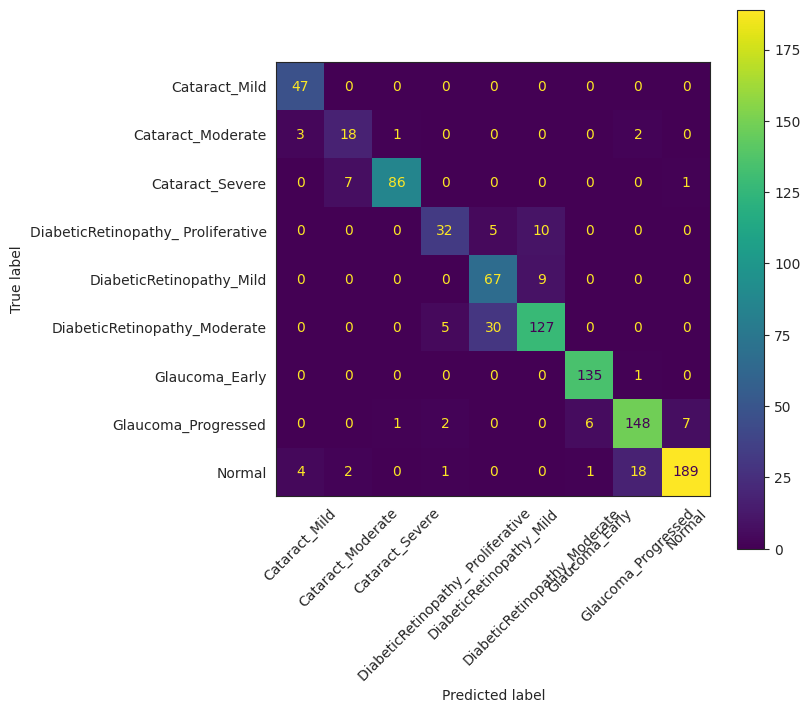

In [ ]:
#Confusion matrix
print('Total Number Of Test data: ', len(test_labels))

sn.set_style("white")
def plot_confusion_matrix(conf_mat, classes):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(7,7)) # change the plot size
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp = disp.plot(include_values=True,cmap='viridis', ax=ax, xticks_rotation=45)
    plt.show()

# Get your confusion matrix
conf_mat = conf_mat

# Using label_encoder.classes_ guarantees that class_names matches
# the order that was used during the one-hot encoding process
class_names = label_encoder.classes_

# Now plot using the function
plot_confusion_matrix(conf_mat, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


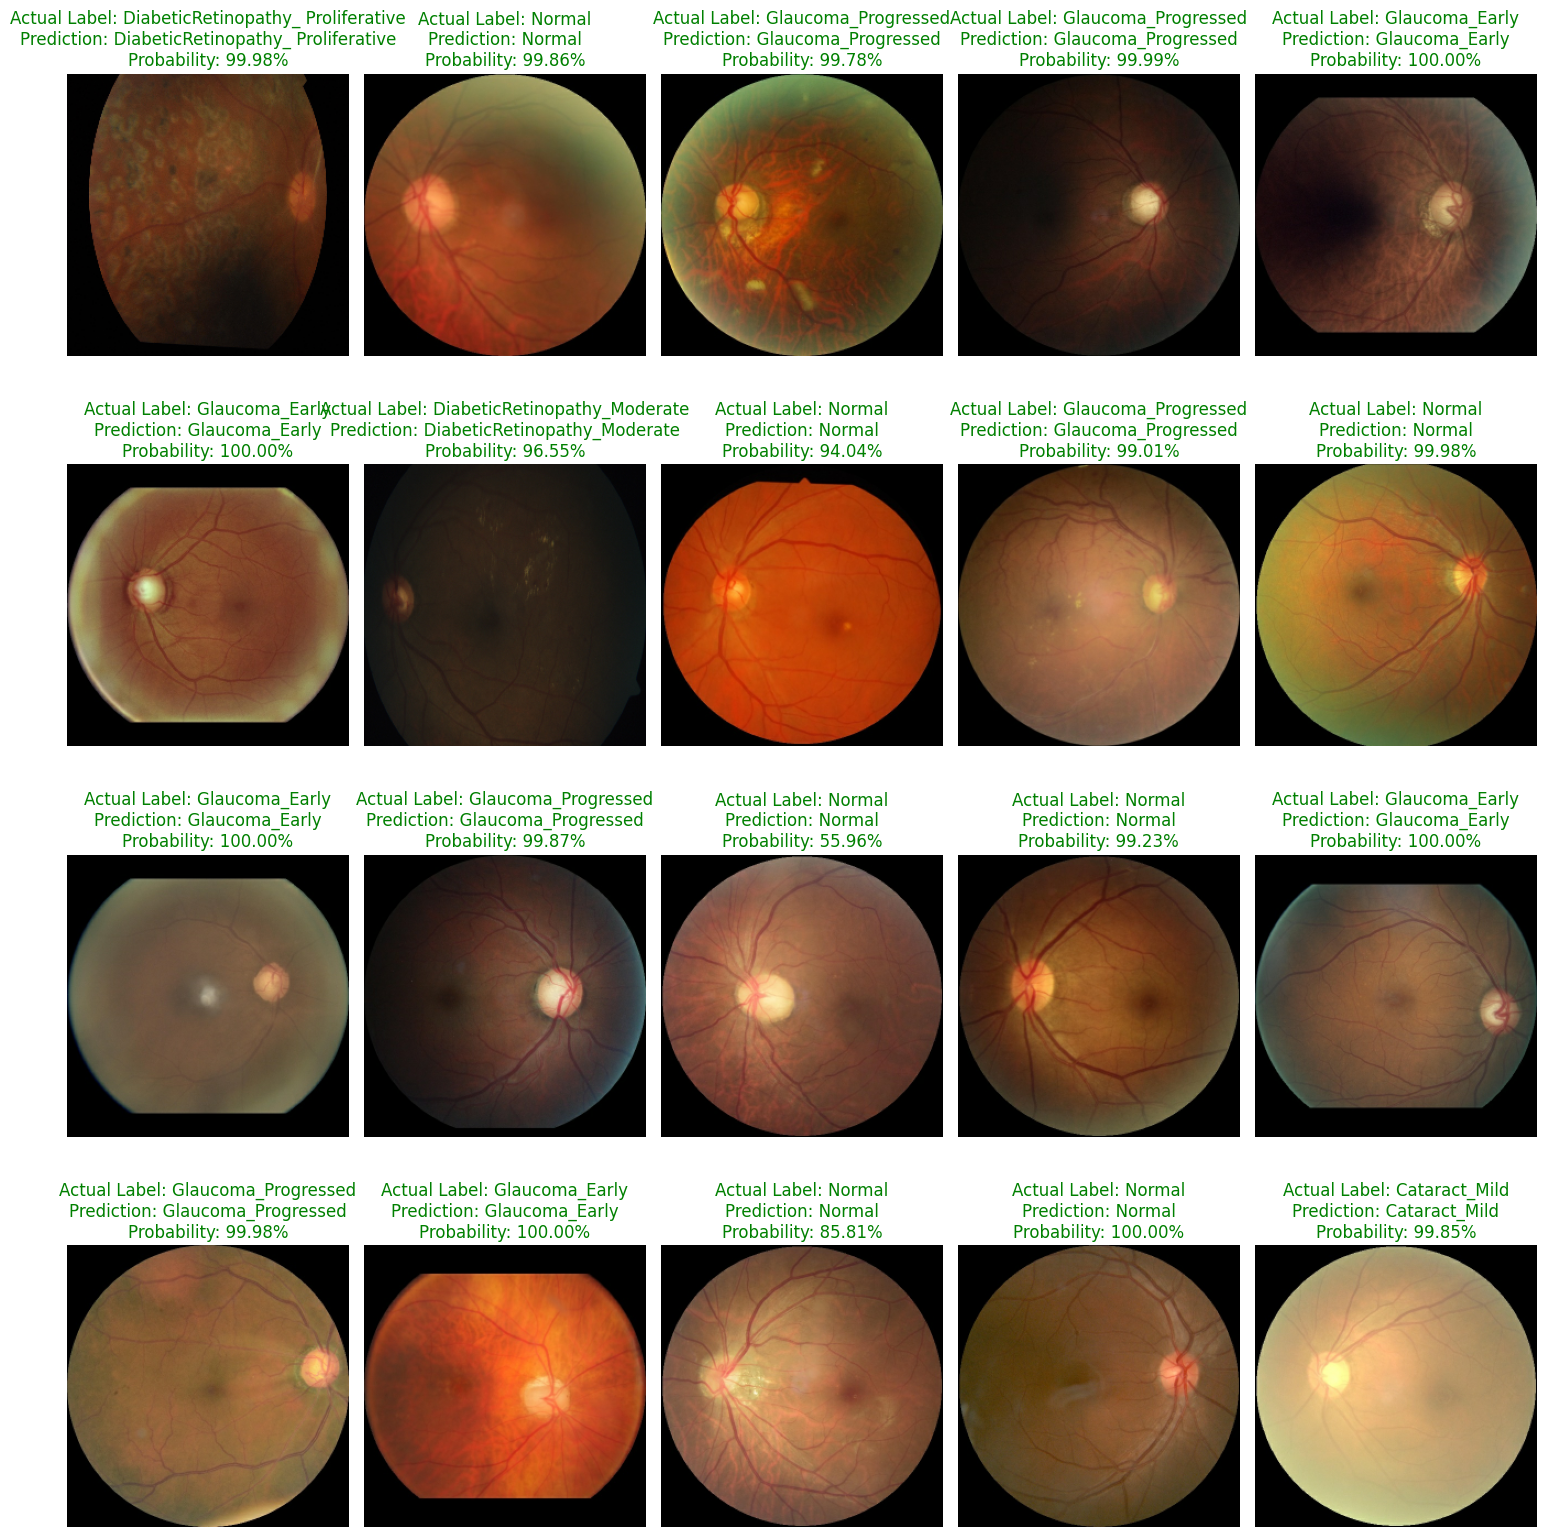

In [ ]:
# probability explanation in below function:
# For example, if the model predicts an image as class B with a probability of 0.7 (or 70%),
# the plot will show "Probability: 70%".
# This means the model is 70% confident that the image belongs to class B.

def plot_test_predictions(model, test_dataset, class_labels, num_images=20):
    """
    Plots the predictions of a model on the test dataset.

    Parameters:
    - model: Trained Keras model to be used for prediction.
    - test_dataset: TensorFlow dataset containing the test images and labels.
    - class_labels: List of class labels.
    - num_images: Number of test images to plot (default is 20).
    """

    # Initialize lists to accumulate images and labels
    images = []
    true_labels = []
    pred_labels = []
    pred_probs = []

    for batch_images, batch_labels in test_dataset:
        # Predict on the batch
        batch_pred_probs = model.predict(batch_images)
        batch_pred_labels = np.argmax(batch_pred_probs, axis=1)

        # Accumulate images and labels
        images.extend(batch_images)
        true_labels.extend(batch_labels)
        pred_labels.extend(batch_pred_labels)
        pred_probs.extend(np.max(batch_pred_probs, axis=1) * 100)

        if len(images) >= num_images:
            break

    # Plot the images with predictions
    plt.figure(figsize=(15, 20))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        actual_label = class_labels[true_labels[i]]
        predicted_label = class_labels[pred_labels[i]]
        probability = pred_probs[i]  # Probability of the predicted class

        color = 'green' if actual_label == predicted_label else 'red'
        plt.title(f"Actual Label: {actual_label}\nPrediction: {predicted_label}\nProbability: {probability:.2f}%",
                  color=color, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use the function
plot_test_predictions(best_model, test_dataset, class_labels=class_names, num_images=20)